In [1]:
import pandas as pd
import sys
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
datadir = "/media/sf_VBox_Shared/London/raw/next161/accelerometer_5second/"
path_to_file5sec = os.path.join(datadir, "__016563_2014-08-08 12-02-19.bin_day1.csv")

In [3]:
filenames = os.listdir(datadir)
datasets = [pd.read_csv(os.path.join(datadir,fn)) for fn in filenames if os.path.isfile(os.path.join(datadir,fn))]
print(len(datasets))

299


In [4]:
for i in range(len(datasets)):
    print(sum(datasets[i]['invalid'] == 1), datasets[i].shape)

(3780, (17280, 6))
(9180, (17280, 6))
(0, (17280, 6))
(5040, (17280, 6))
(0, (17280, 6))
(0, (17280, 6))
(0, (17280, 6))
(4860, (17280, 6))
(0, (17280, 6))
(1440, (17280, 6))
(5760, (17280, 6))
(7920, (17280, 6))
(1440, (17280, 6))
(5040, (17280, 6))
(1260, (17280, 6))
(0, (17280, 6))
(540, (17280, 6))
(5220, (17280, 6))
(2520, (17280, 6))
(10260, (17280, 6))
(0, (17280, 6))
(4860, (17280, 6))
(0, (17280, 6))
(4680, (17280, 6))
(0, (17280, 6))
(0, (17280, 6))
(0, (17280, 6))
(0, (17280, 6))
(0, (17280, 6))
(1800, (17280, 6))
(720, (17280, 6))
(3420, (17280, 6))
(15840, (17280, 6))
(11340, (17280, 6))
(1980, (17280, 6))
(0, (17280, 6))
(0, (17280, 6))
(900, (17280, 6))
(0, (17280, 6))
(0, (17280, 6))
(0, (17280, 6))
(4680, (17280, 6))
(1440, (17280, 6))
(6120, (17280, 6))
(7560, (17280, 6))
(5400, (17280, 6))
(3240, (17280, 6))
(1080, (17280, 6))
(0, (17280, 6))
(2160, (17280, 6))
(3780, (17280, 6))
(0, (17280, 6))
(0, (17280, 6))
(4860, (17280, 6))
(0, (17280, 6))
(2700, (17280, 6))
(3

In [6]:
all_data = pd.concat(datasets)

## Explore distributions

In [7]:
all_acceleration = all_data['acceleration']
print all_acceleration.shape

(5166720,)


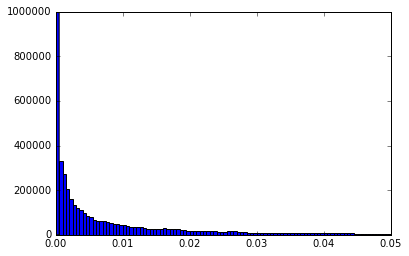

In [8]:
plt.hist(all_acceleration[all_acceleration<0.05], bins=100)
plt.xlim(0, 0.05)
plt.show()

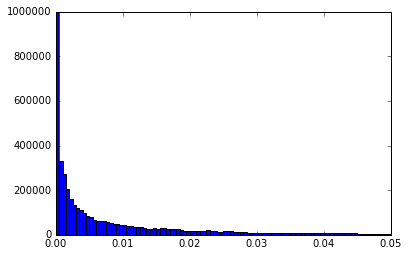

In [9]:
log_acceleration =  np.log(all_acceleration+1)
plt.hist(log_acceleration[log_acceleration<0.05], bins=100)
#plt.xlim(0, 0.05)
#plt.ylim(0,2000)
plt.show()

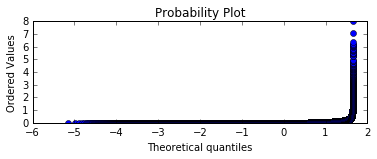

In [10]:
from scipy import stats
fig = plt.figure()
ax1 = fig.add_subplot(211)
stats.probplot(all_acceleration, dist=stats.norm, plot=ax1)
plt.show()

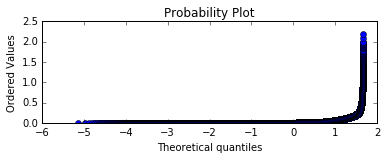

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
stats.probplot(log_acceleration, dist=stats.norm, plot=ax1)
plt.show()

In [ ]:
vals = np.sqrt(all_acceleration)
df, loc, scale = stats.chi2.fit(vals)
print(df, loc, scale)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
stats.probplot(vals, dist=stats.chi2, sparams=(df, loc, scale), plot=ax1)
plt.show()

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
shape, loc, scale = stats.weibull_min.fit(all_acceleration)
stats.probplot(all_acceleration, dist=stats.weibull_min, sparams=(shape, loc, scale), plot=ax1)
plt.show()

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
shape, loc, scale = stats.weibull_min.fit(log_acceleration)
stats.probplot(log_acceleration, dist=stats.weibull_min, sparams=(shape, loc, scale), plot=ax1)
plt.show()

## Box-Cox

In [ ]:
bc_acceleration, bc_lmbda = stats.boxcox(all_acceleration+1)

In [ ]:
fig = plt.figure()
ax2 = fig.add_subplot(211)
stats.probplot(bc_acceleration, dist=stats.norm, plot=ax2)
plt.show()

In [ ]:
bc_lmbda

In [ ]:
log_acceleration =  np.log(all_acceleration+1)
plt.hist(bc_acceleration, bins=100)
plt.show()

## Angles

In [ ]:
#Create boxplots for each sequence for the angles
#We expect x (and thus anglex) to be distributed either mostly on the negative or mostly on the positive half
fig, axes = plt.subplots(len(datasets), figsize=(10, 50))
for i, dataset in enumerate(datasets):
    print(np.median(dataset['anglex']), np.median(dataset['angley']))
    axes[i].boxplot([dataset['anglex'], dataset['angley'], dataset['anglez']], labels=['x', 'y', 'z']);

In [ ]:
# Switch the sign of angle x and y if the orientation seems to be switcht
dataset_switched = [dataset.copy() for dataset in datasets]
for dataset in dataset_switched:
    non_sleeping_indices = dataset['Activity'] != 'Sleepingandresting(includingsickinbed)'
    non_sleeping = dataset[non_sleeping_indices]
    if not non_sleeping.empty:
        # in the 'correct' orientation, anglex should be mostly negative
        med_x = np.median(non_sleeping['anglex'])
        print(med_x)
        if med_x > 0:
            dataset['anglex'] *= -1
            dataset['angley'] *= -1
    else:
        print('sleeping: ', np.median(dataset['anglex']))

In [ ]:
# Look at the distrubtions per activity
by_act = all_data.groupby('Activity')
fig, axes = plt.subplots(len(by_act), figsize=(10, 50))
for i, (activity, dataset) in enumerate(by_act):
    axes[i].boxplot([dataset['anglex'], dataset['angley'], dataset['anglez']], labels=['x', 'y', 'z'])
    axes[i].set_title(activity)

In [ ]:
anglex = np.array([s for d in datasets for s in list(np.array(d['anglex']))])
angley = np.array([s for d in datasets for s in list(np.array(d['angley']))])
anglez = np.array([s for d in datasets for s in list(np.array(d['anglez']))])

In [ ]:
total = anglex + angley + anglez

In [ ]:
plt.boxplot(total);

In [ ]:
print(min(total), max(total))

In [ ]:
print min(anglex), max(anglex)
print min(angley), max(angley)
print min(anglez), max(anglez)

In [ ]:
radtodegree = 180/np.pi
theta = anglex/radtodegree
psi = angley/radtodegree
phi = anglez/radtodegree

In [ ]:
x = np.sin(theta)
y = np.sin(psi)
z = np.tan(phi)*np.sqrt(x**2 + y**2)

In [ ]:
acc = x**2 + y**2 + z**2
plt.boxplot(acc);

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color='black', s=5)

In [ ]:
print min(anglex + angley), max(anglex + angley)

In [ ]:
radtodegree = np.pi/180
radius = np.sin(anglex/radtodegree)**2 + np.sin(angley/radtodegree)**2 + np.sin(anglez/radtodegree)**2
plt.boxplot(radius);

In [ ]:
fig = subplots(figsize=(15, 15))
plt.scatter(anglex, anglez, color='black', s=5);